# Crunch pathways

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os.path

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrcmip.stats
import scipy.stats
import scmdata
import tqdm.autonotebook as tqdman
import tqdm.contrib.concurrent
from openscm_units import unit_registry

import one_earth.landuse_pathways
import utils

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/one-earth-2022/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>

In [3]:
dotenv.load_dotenv()

True

<IPython.core.display.Javascript object>

In [4]:
SPECS_FILE = os.path.join(
    utils.DATA_DIR,
    "interim",
    "pathway-specs",
    "clean-specs_{}.csv".format(utils.SPECS_HANDLING_ID),
)
SPECS_FILE

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/interim/pathway-specs/clean-specs_7d7c42.csv'

<IPython.core.display.Javascript object>

In [5]:
OUT_FILE = os.path.join(
    utils.DATA_DIR,
    "processed",
    "pathways",
    "co2-uptake-pathways_{}.nc".format(utils.UPTAKE_PATHWAYS_ID),
)
os.makedirs(os.path.dirname(OUT_FILE), exist_ok=True)
OUT_FILE

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/processed/pathways/co2-uptake-pathways_7d7c42.nc'

<IPython.core.display.Javascript object>

In [6]:
NDRAWS = 3 * 10**3
# NDRAWS = 5
MAX_WORKERS = 28

<IPython.core.display.Javascript object>

In [7]:
out_years = np.arange(2020, 4000 + 1)
keep_years = np.arange(2020, 2300 + 1)
model = "One Earth"
scenario = "Climate restoration"

<IPython.core.display.Javascript object>

In [8]:
specs = pd.read_csv(SPECS_FILE)
specs

pathway     region            unit             variable  \
0       Agroforestry  Temperate             Mha  Available land area   
1       Agroforestry  Temperate             Mha  Available land area   
2       Agroforestry  Temperate             Mha  Available land area   
3       Agroforestry  Temperate   dimensionless  Available land area   
4       Agroforestry  Temperate  not-applicable  Available land area   
..               ...        ...             ...                  ...   
355  Reduced Harvest  Temperate              yr           uptake_lag   
356     Agroforestry    Tropics              yr           uptake_lag   
357     Agroforestry  Temperate              yr           uptake_lag   
358     Silvopasture    Tropics              yr           uptake_lag   
359     Silvopasture  Temperate              yr           uptake_lag   

                  value                 name  
0     95.92808508000002               median  
1     86.33527657200001                lower  
2    105.52089358800002                upper  
3                   0.8  confidence_interval  
4          FAOSTAT 2018               source  
..                  ...                  ...  
355                20.0               median  
356                 0.0               median  
357                 0.0               median  
358                 0.0               median  
359                 0.0               median  

[360 rows x 6 columns]

<IPython.core.display.Javascript object>

In [9]:
specs[
    (specs["pathway"] == "Reduced Harvest") & (specs["variable"] == "Saturation time")
]

pathway     region            unit         variable  \
205  Reduced Harvest    Tropics              yr  Saturation time   
206  Reduced Harvest    Tropics              yr  Saturation time   
207  Reduced Harvest    Tropics              yr  Saturation time   
208  Reduced Harvest    Tropics   dimensionless  Saturation time   
209  Reduced Harvest    Tropics  not-applicable  Saturation time   
210  Reduced Harvest     Boreal              yr  Saturation time   
211  Reduced Harvest     Boreal              yr  Saturation time   
212  Reduced Harvest     Boreal              yr  Saturation time   
213  Reduced Harvest     Boreal   dimensionless  Saturation time   
214  Reduced Harvest     Boreal  not-applicable  Saturation time   
215  Reduced Harvest  Temperate              yr  Saturation time   
216  Reduced Harvest  Temperate              yr  Saturation time   
217  Reduced Harvest  Temperate              yr  Saturation time   
218  Reduced Harvest  Temperate   dimensionless  Saturation time   
219  Reduced Harvest  Temperate  not-applicable  Saturation time   

                    value                 name  
205                    60               median  
206                    40                lower  
207                   100                upper  
208                   0.8  confidence_interval  
209     Mackey et al 2020               source  
210                   120               median  
211                    80                lower  
212                   200                upper  
213                   0.8  confidence_interval  
214  Luyssaert et al 2008               source  
215                   100               median  
216                    80                lower  
217                   125                upper  
218                   0.8  confidence_interval  
219        Law et al 2018               source

<IPython.core.display.Javascript object>

In [10]:
bounds = {
    "areas": 1,
    "max_rate_per_areas": -(10**3),
    "max_total_per_areas": 0.01,
    "saturation_periods": 1,
    "phase_in_periods": 1,
    "phase_out_periods": 1,
}
specs_map = {
    "areas": "Available land area",
    "max_rate_per_areas": "Maximum flux rate per area",
    "max_total_per_areas": "Available carbon density",
    "saturation_periods": "Saturation time",
    "phase_in_periods": "phase_in time",
    "phase_out_periods": "phase_out time",
}

<IPython.core.display.Javascript object>

In [11]:
def get_bounded_skewed_normal(
    median, lower, upper, confidence_interval, bound=1, ndraws=NDRAWS, seed=984721
):
    np.random.seed(seed)
    out = pyrcmip.stats.get_skewed_normal(
        median=median,
        lower=lower,
        upper=upper,
        conf=confidence_interval,
        input_data=np.random.random(ndraws),
    )
    out[np.where(out < bound)] = bound

    return out

<IPython.core.display.Javascript object>

In [12]:
def extract_draws(v, df, seed):
    lower_bound = bounds[v]
    specs_name = specs_map[v]

    df_vn = df.set_index(["variable", "name"]).loc[specs_name]

    values = df_vn.loc[["median", "lower", "upper"]]
    unit = values["unit"].unique()
    assert len(unit) == 1
    unit = unit[0]

    median = float(values.loc["median", "value"])
    lower = float(values.loc["lower", "value"])
    upper = float(values.loc["upper", "value"])

    if median > upper:
        raise ValueError("{}  >= {}. {}".format(median, upper, df))
    if median == upper == lower:
        return (median * np.ones(NDRAWS), unit)

    return (
        get_bounded_skewed_normal(
            median=median,
            upper=upper,
            lower=lower,
            confidence_interval=float(df_vn.loc["confidence_interval", "value"]),
            bound=lower_bound,
            seed=seed,
            ndraws=NDRAWS,
        ),
        unit,
    )

<IPython.core.display.Javascript object>

In [13]:
def get_pathway(inp):
    (
        pathway,
        region,
        ensemble_member,
        start_year,
        uptake_lag,
        uptake_lag_unit,
        cfgs,
    ) = inp

    from openscm_units import unit_registry

    kwargs = {k: v[0] * unit_registry(v[1]) for k, v in cfgs.items()}
    kwargs["saturation_period"] -= uptake_lag * unit_registry(uptake_lag_unit)
    if kwargs["saturation_period"].magnitude < 0:
        print(f"Saturation period went negative for {pathway} {region}")
        kwargs["saturation_period"] *= 0

    out = one_earth.landuse_pathways.create_landuse_pathway(
        **kwargs,
        start_year=start_year + uptake_lag,
        out_years=out_years,
        model=model,
        scenario=scenario,
        variable="Uptake|CO2|{}".format(pathway),
        region=region,
        raise_if_greater_than_max=False,
    ).filter(year=keep_years)
    out["ensemble_member"] = ensemble_member

    return out

<IPython.core.display.Javascript object>

In [14]:
SERIAL = True
SERIAL = False
q = [5, 50, 95]
cumulative_uptake_until = 2100

seeds = [
    129858,
    3958,
    234875,
    456135,
    488568,
    5531886,
    481856,
    515384,
    5399841,
    1866574,
    9875624,
    1665487,
]
all_draws = []
derived_stats = []
for j, ((pathway, region), df) in enumerate(
    tqdman.tqdm(specs.groupby(["pathway", "region"]))
):
    #     if pathway != "Reduced Harvest":
    #         continue

    try:
        configs = {
            v: extract_draws(v, df, seeds[j])
            for v in [
                "areas",
                "max_rate_per_areas",
                "max_total_per_areas",
                "saturation_periods",
                "phase_in_periods",
                "phase_out_periods",
            ]
        }
        start_year = int(float(df[df["variable"] == "start_year"]["value"]))
        uptake_lag = int(float(df[df["variable"] == "uptake_lag"]["value"]))
        uptake_lag_unit = str(df[df["variable"] == "uptake_lag"]["unit"].iloc[0])

        calc_params = [
            (
                pathway,
                region,
                i,
                start_year,
                uptake_lag,
                uptake_lag_unit,
                {k[:-1]: (v[0][i], v[1]) for k, v in configs.items()},
            )
            for i in range(NDRAWS)
        ]
        
        if SERIAL:
            draws = [get_pathway(v) for v in tqdman.tqdm(calc_params)]
        else:
            draws = tqdm.contrib.concurrent.process_map(
                get_pathway,
                calc_params,
                max_workers=MAX_WORKERS,
                desc="Crunching {} {}".format(pathway, region),
                chunksize=5,
            )

        draws

        all_draws += draws

    except Exception as exc:
        print("Failed for {} {}".format(pathway, region))
        print(str(exc))
        print()

#     break

all_draws = (
    scmdata.run_append(all_draws)
    .filter(year=range(1, 2500 + 1))
    .convert_unit("GtC / yr")
)
all_draws

  0%|          | 0/12 [00:00<?, ?it/s]

Crunching Agroforestry Temperate:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Agroforestry Tropics:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Forest Ecosystem Restoration Boreal:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Forest Ecosystem Restoration Temperate:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Forest Ecosystem Restoration Tropics:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Reduced Harvest Boreal:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Reduced Harvest Temperate:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Reduced Harvest Tropics:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Reforestation Temperate:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Reforestation Tropics:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Silvopasture Temperate:   0%|          | 0/3000 [00:00<?, ?it/s]

Crunching Silvopasture Tropics:   0%|          | 0/3000 [00:00<?, ?it/s]

<ScmRun (timeseries: 36000, timepoints: 281)>
Time:
	Start: 2020-01-01T00:00:00
	End: 2300-01-01T00:00:00
Meta:
	       ensemble_member      model     region             scenario      unit  \
	0                    0  One Earth  Temperate  Climate restoration  GtC / yr   
	1                    1  One Earth  Temperate  Climate restoration  GtC / yr   
	2                    2  One Earth  Temperate  Climate restoration  GtC / yr   
	3                    3  One Earth  Temperate  Climate restoration  GtC / yr   
	4                    4  One Earth  Temperate  Climate restoration  GtC / yr   
	...                ...        ...        ...                  ...       ...   
	35995             2995  One Earth    Tropics  Climate restoration  GtC / yr   
	35996             2996  One Earth    Tropics  Climate restoration  GtC / yr   
	35997             2997  One Earth    Tropics  Climate restoration  GtC / yr   
	35998             2998  One Earth    Tropics  Climate restoration  GtC / yr   
	35999  

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/one-earth-2022/lib/python3.7/site-packages/scmdata/run.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


(-0.5, 0.5)

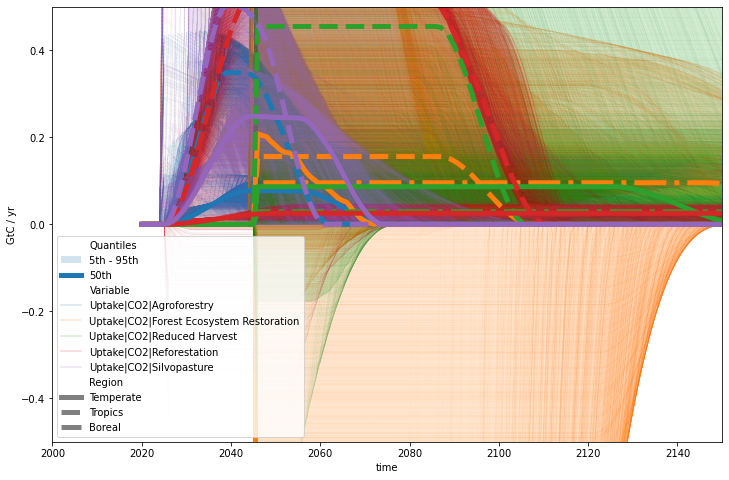

<IPython.core.display.Javascript object>

In [15]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)

ax = all_draws.lineplot(
    hue="variable",
    style="region",
    units="ensemble_member",
    estimator=None,
    linewidth=0.25,
    alpha=0.1,
    time_axis="year",
    ax=ax,
)
all_draws.plumeplot(
    hue_var="variable",
    hue_label="Variable",
    quantile_over="ensemble_member",
    style_var="region",
    style_label="Region",
    time_axis="year",
    quantiles_plumes=[((0.05, 0.95), 0.2), ((0.5,), 1.0)],
    linewidth=5,
    ax=ax,
)
ax.set_xlim([2000, 2150])
ax.set_ylim([-0.5, 0.5])

In [16]:
uptake_co2_global = all_draws.process_over("region", "sum")
uptake_co2_global["region"] = "World"
uptake_co2_global = scmdata.ScmRun(uptake_co2_global)
display(uptake_co2_global)

uptake_co2_total = all_draws.process_over("variable", "sum")
uptake_co2_total["variable"] = "Uptake|CO2"
uptake_co2_total = scmdata.ScmRun(uptake_co2_total)
display(uptake_co2_total)

uptake_co2_total_global = uptake_co2_total.process_over("region", "sum")
uptake_co2_total_global["region"] = "World"
uptake_co2_total_global = scmdata.ScmRun(uptake_co2_total_global)
display(uptake_co2_total_global)

<ScmRun (timeseries: 15000, timepoints: 281)>
Time:
	Start: 2020-01-01T00:00:00
	End: 2300-01-01T00:00:00
Meta:
	       ensemble_member      model region             scenario      unit  \
	0                    0  One Earth  World  Climate restoration  GtC / yr   
	1                    1  One Earth  World  Climate restoration  GtC / yr   
	2                    2  One Earth  World  Climate restoration  GtC / yr   
	3                    3  One Earth  World  Climate restoration  GtC / yr   
	4                    4  One Earth  World  Climate restoration  GtC / yr   
	...                ...        ...    ...                  ...       ...   
	14995             2995  One Earth  World  Climate restoration  GtC / yr   
	14996             2996  One Earth  World  Climate restoration  GtC / yr   
	14997             2997  One Earth  World  Climate restoration  GtC / yr   
	14998             2998  One Earth  World  Climate restoration  GtC / yr   
	14999             2999  One Earth  World  Climate r

<ScmRun (timeseries: 9000, timepoints: 281)>
Time:
	Start: 2020-01-01T00:00:00
	End: 2300-01-01T00:00:00
Meta:
	      ensemble_member      model     region             scenario      unit  \
	0                   0  One Earth     Boreal  Climate restoration  GtC / yr   
	1                   0  One Earth  Temperate  Climate restoration  GtC / yr   
	2                   0  One Earth    Tropics  Climate restoration  GtC / yr   
	3                   1  One Earth     Boreal  Climate restoration  GtC / yr   
	4                   1  One Earth  Temperate  Climate restoration  GtC / yr   
	...               ...        ...        ...                  ...       ...   
	8995             2998  One Earth  Temperate  Climate restoration  GtC / yr   
	8996             2998  One Earth    Tropics  Climate restoration  GtC / yr   
	8997             2999  One Earth     Boreal  Climate restoration  GtC / yr   
	8998             2999  One Earth  Temperate  Climate restoration  GtC / yr   
	8999             29

<ScmRun (timeseries: 3000, timepoints: 281)>
Time:
	Start: 2020-01-01T00:00:00
	End: 2300-01-01T00:00:00
Meta:
	      ensemble_member      model region             scenario      unit  \
	0                   0  One Earth  World  Climate restoration  GtC / yr   
	1                   1  One Earth  World  Climate restoration  GtC / yr   
	2                   2  One Earth  World  Climate restoration  GtC / yr   
	3                   3  One Earth  World  Climate restoration  GtC / yr   
	4                   4  One Earth  World  Climate restoration  GtC / yr   
	...               ...        ...    ...                  ...       ...   
	2995             2995  One Earth  World  Climate restoration  GtC / yr   
	2996             2996  One Earth  World  Climate restoration  GtC / yr   
	2997             2997  One Earth  World  Climate restoration  GtC / yr   
	2998             2998  One Earth  World  Climate restoration  GtC / yr   
	2999             2999  One Earth  World  Climate restoration  G

<IPython.core.display.Javascript object>

In [17]:
all_draws_out = scmdata.run_append(
    [all_draws, uptake_co2_total, uptake_co2_total_global, uptake_co2_global]
)
all_draws_out

<ScmRun (timeseries: 63000, timepoints: 281)>
Time:
	Start: 2020-01-01T00:00:00
	End: 2300-01-01T00:00:00
Meta:
	       ensemble_member      model     region             scenario      unit  \
	0                    0  One Earth  Temperate  Climate restoration  GtC / yr   
	1                    1  One Earth  Temperate  Climate restoration  GtC / yr   
	2                    2  One Earth  Temperate  Climate restoration  GtC / yr   
	3                    3  One Earth  Temperate  Climate restoration  GtC / yr   
	4                    4  One Earth  Temperate  Climate restoration  GtC / yr   
	...                ...        ...        ...                  ...       ...   
	62995             2995  One Earth      World  Climate restoration  GtC / yr   
	62996             2996  One Earth      World  Climate restoration  GtC / yr   
	62997             2997  One Earth      World  Climate restoration  GtC / yr   
	62998             2998  One Earth      World  Climate restoration  GtC / yr   
	62999  

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/one-earth-2022/lib/python3.7/site-packages/scmdata/run.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


(2000.0, 2350.0)

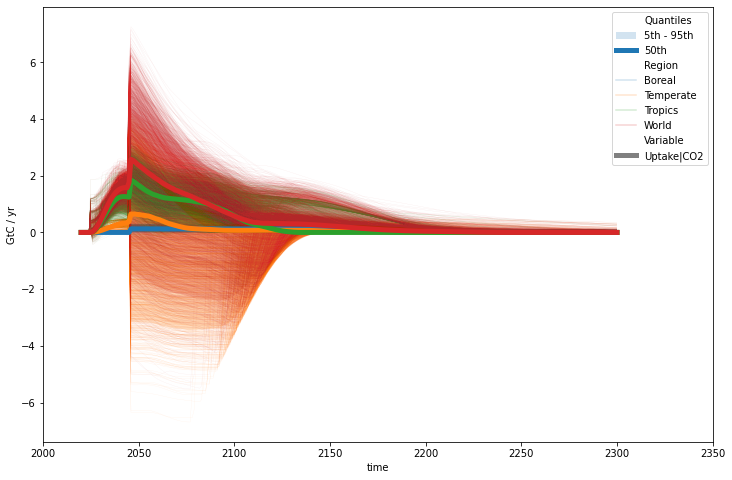

<IPython.core.display.Javascript object>

In [18]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)

ax = all_draws_out.filter(variable="Uptake|CO2").lineplot(
    hue="region",
    style="variable",
    units="ensemble_member",
    estimator=None,
    linewidth=0.25,
    alpha=0.1,
    time_axis="year",
    ax=ax,
)
ax, lh = all_draws_out.filter(variable="Uptake|CO2").plumeplot(
    hue_var="region",
    hue_label="Region",
    quantile_over="ensemble_member",
    style_var="variable",
    style_label="Variable",
    time_axis="year",
    quantiles_plumes=[((0.05, 0.95), 0.2), ((0.5,), 1.0)],
    linewidth=5,
    ax=ax,
)
ax.set_xlim([2000, 2350])
# ax.legend(handles=lh, loc="best", handlelength=5)

/data/ubuntu-znicholls/miniconda3/envs/one-earth-2022/lib/python3.7/site-packages/scmdata/run.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


(2000.0, 2350.0)

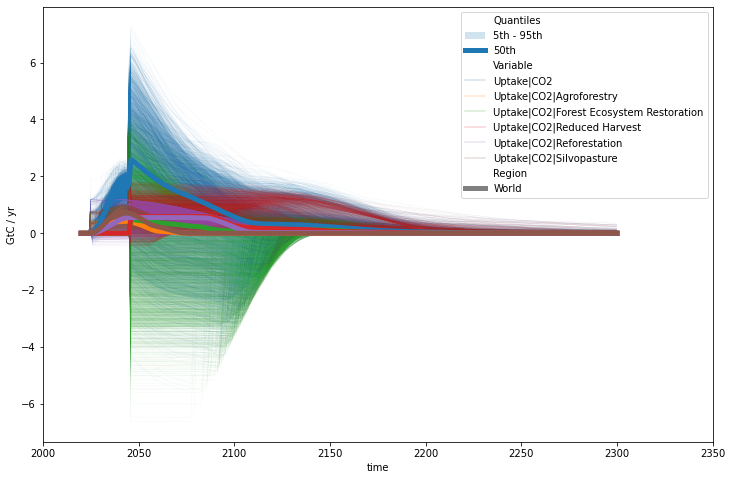

<IPython.core.display.Javascript object>

In [19]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)

ax = all_draws_out.filter(region="World").lineplot(
    hue="variable",
    style="region",
    units="ensemble_member",
    estimator=None,
    linewidth=0.25,
    alpha=0.1,
    time_axis="year",
    ax=ax,
)
ax, lh = (
    all_draws_out.filter(region="World")
    #     .integrate()
    .plumeplot(
        hue_var="variable",
        hue_label="Variable",
        quantile_over="ensemble_member",
        style_var="region",
        style_label="Region",
        time_axis="year",
        quantiles_plumes=[((0.05, 0.95), 0.2), ((0.5,), 1.0)],
        linewidth=5,
        ax=ax,
    )
)
ax.set_xlim([2000, 2350])
# ax.legend(handles=lh, loc="best", handlelength=5)

In [20]:
all_draws_out.filter(year=range(1, 2300 + 1)).to_nc(
    OUT_FILE, dimensions=("region", "ensemble_member", "variable")
)

<IPython.core.display.Javascript object>

In [21]:
!du -sh {OUT_FILE}

155M	/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/processed/pathways/co2-uptake-pathways_7d7c42.nc


<IPython.core.display.Javascript object>

In [22]:
!ncdump -h {OUT_FILE}

netcdf co2-uptake-pathways_7d7c42 {
dimensions:
	time = 281 ;
	ensemble_member = 3000 ;
	region = 4 ;
variables:
	int64 time(time) ;
		time:units = "days since 2020-01-01 00:00:00.000000" ;
		time:calendar = "standard" ;
	int64 ensemble_member(ensemble_member) ;
	string region(region) ;
	double Uptake__CO2(region, ensemble_member, time) ;
		Uptake__CO2:_FillValue = NaN ;
		Uptake__CO2:units = "GtC / yr" ;
		Uptake__CO2:long_name = "Uptake|CO2" ;
	double Uptake__CO2__Agroforestry(region, ensemble_member, time) ;
		Uptake__CO2__Agroforestry:_FillValue = NaN ;
		Uptake__CO2__Agroforestry:units = "GtC / yr" ;
		Uptake__CO2__Agroforestry:long_name = "Uptake|CO2|Agroforestry" ;
	double Uptake__CO2__Forest_Ecosystem_Restoration(region, ensemble_member, time) ;
		Uptake__CO2__Forest_Ecosystem_Restoration:_FillValue = NaN ;
		Uptake__CO2__Forest_Ecosystem_Restoration:units = "GtC / yr" ;
		Uptake__CO2__Forest_Ecosystem_Restoration:long_name = "Uptake|CO2|Forest Ecosystem Restoration" ;
	double 

<IPython.core.display.Javascript object>